In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

from sklearn import metrics,linear_model,feature_selection,preprocessing,decomposition, model_selection, ensemble

from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn import calibration

from imblearn import under_sampling,over_sampling

import category_encoders as ce

from xgboost import XGBClassifier
import pickle


from skopt.space import Space,Real, Integer,Categorical
from skopt.utils import use_named_args
from skopt.optimizer import gp_minimize

%load_ext autoreload
%autoreload 2
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# functions for later
def to_named_params(space, params):
    return {dimension.name: param for dimension, param in zip(space, params)}

In [3]:
# load data
loan_df = pd.read_csv('../data/Ex2 - Data sample.csv')
loan_df = loan_df.drop(columns=['Unnamed: 0']).set_index('ID')
loan_df.head()

,Fold,Target,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,...,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163
ID,,,,,,,,,,,,,,,,,,,,,
1,IS,0,40,3,1,5304.570,0,18.609524,8,1,...,0,0,0,1,0,0,0,53.04570,1,6
2,IS,0,26,4,1,884.095,0,25.970874,13,1,...,0,0,0,0,0,0,0,884.09500,3,5
3,IS,0,30,2,1,3536.380,0,25.686275,46,1,...,0,0,0,1,0,0,0,88.40950,1,0
4,IS,0,52,1,1,884.095,0,18.019608,17,1,...,0,0,0,0,0,0,0,353.63800,7,2
5,IS,0,31,2,1,9725.045,0,28.666667,24,0,...,0,0,0,0,0,0,0,8.84095,9,3


In [4]:
# check for nulls
loan_df.columns[loan_df.isna().sum(0)>0]

Index([], dtype='object')

In [5]:
# load varaible types
colum_types = pd.read_excel('../data/Ex2 - Dictionary.xlsx')
colum_types.head()                         

,Var,Type
0,ID,Id variable
1,Fold,Fold variable (IS/OS)
2,Target,Dependent variable (0/1)
3,Var4,Continuous
4,Var5,Categorical Ordinal


In [6]:
colum_types.groupby('Type').Var.count()

Type
Categorical Nominal          9
Categorical Ordinal         49
Continuous                  33
Dependent variable (0/1)     1
Dummy                       69
Fold variable (IS/OS)        1
Id variable                  1
Name: Var, dtype: int64

In [7]:
# create type col grouper
col_type = dict()
for Type in colum_types['Type'].unique():
    col_type[Type] = colum_types.query(f'Type == "{Type}"').Var.values
# remove not features dtypes
for Type in ['Id variable', 'Fold variable (IS/OS)','Dependent variable (0/1)']:
    col_type.pop(Type)
col_type

{'Continuous': array(['Var4', 'Var7', 'Var9', 'Var10', 'Var13', 'Var14', 'Var20',
        'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var44',
        'Var54', 'Var55', 'Var56', 'Var57', 'Var72', 'Var73', 'Var81',
        'Var82', 'Var83', 'Var84', 'Var85', 'Var95', 'Var114', 'Var129',
        'Var130', 'Var131', 'Var136', 'Var161', 'Var163'], dtype=object),
 'Categorical Ordinal': array(['Var5', 'Var29', 'Var30', 'Var32', 'Var34', 'Var45', 'Var46',
        'Var47', 'Var48', 'Var49', 'Var50', 'Var51', 'Var60', 'Var70',
        'Var71', 'Var74', 'Var75', 'Var76', 'Var77', 'Var78', 'Var79',
        'Var80', 'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91',
        'Var105', 'Var106', 'Var107', 'Var108', 'Var109', 'Var110',
        'Var111', 'Var112', 'Var113', 'Var116', 'Var117', 'Var118',
        'Var119', 'Var120', 'Var121', 'Var122', 'Var123', 'Var124',
        'Var125', 'Var135', 'Var143'], dtype=object),
 'Dummy': array(['Var6', 'Var8', 'Var11', 'Var12', 'Var15', 'Var1

In [8]:
loan_df[col_type['Continuous']].describe()

,Var4,Var7,Var9,Var10,Var13,Var14,Var20,Var21,Var22,Var24,...,Var84,Var85,Var95,Var114,Var129,Var130,Var131,Var136,Var161,Var163
count,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.0,13015.000000,13015.000000,13015.000000,...,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000
mean,38.432885,1711.539762,15.369281,9.961583,10.328467,26.429985,100.0,9.137841,125.220054,304.430673,...,23.156819,0.711149,10.426316,3.022359,0.493732,5.600393,2.415435,12.679066,108.306706,4.474453
std,7.625791,3564.157915,5.217711,9.568189,6.240978,13.555245,0.0,6.459344,183.094623,233.527497,...,2.758015,0.094874,5.798972,1.812870,0.348556,4.858148,2.290024,9.518014,253.951448,1.938014
min,22.000000,22.092093,5.448458,1.000000,1.000000,1.000000,100.0,2.000000,4.000000,29.731200,...,12.000000,0.500000,2.000000,0.000000,0.033300,1.000000,0.200000,0.632456,0.764254,0.000000
25%,33.000000,297.716000,11.846815,3.000000,6.000000,15.000000,100.0,4.000000,16.000000,162.696000,...,24.000000,0.633333,6.000000,2.000000,0.250000,3.000000,1.000000,6.306082,12.799950,3.000000
50%,39.000000,644.556000,14.932039,7.000000,9.000000,25.000000,100.0,7.000000,49.000000,245.344500,...,24.000000,0.700000,9.500000,3.000000,0.400000,4.166700,1.666700,10.290773,32.076400,5.000000
75%,44.000000,1569.380000,18.377537,13.000000,14.000000,30.000000,100.0,12.000000,144.000000,362.561300,...,24.000000,0.766667,13.500000,4.000000,0.666700,6.666700,3.333300,16.276772,81.439000,6.000000
max,55.000000,23135.055000,43.768319,50.000000,35.000000,70.000000,100.0,30.000000,900.000000,1662.166600,...,36.000000,0.966667,28.000000,8.000000,2.000000,37.500000,16.666700,48.759560,2919.220000,10.000000


In [9]:
loan_df[col_type['Categorical Nominal']].describe()

,Var19,Var23,Var26,Var27,Var68,Var93,Var133,Var134,Var162
count,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000,13015.000000
mean,1.032424,1.888129,1.824587,0.824587,2.312486,1.223204,1.502651,1.502651,2.752439
std,0.345370,0.693618,0.380335,0.380335,1.065408,0.847645,0.743997,0.743997,2.383998
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000
75%,1.000000,2.000000,2.000000,1.000000,3.000000,1.000000,2.000000,2.000000,3.000000
max,5.000000,4.000000,2.000000,1.000000,5.000000,6.000000,4.000000,4.000000,10.000000


In [10]:
loan_df.groupby(['Fold','Target']).count().Var4

Fold  Target
IS    0         8043
      1          199
OS    0         4691
      1           82
Name: Var4, dtype: int64

Looks like a heavy class imbalance

In [11]:
# remove columns with 1 unique value
for Type in col_type:
    n_unique = loan_df[col_type[Type]].nunique()
    col_type[Type] = col_type[Type][n_unique >1]


In [12]:
# split data in to training, validation, and out sample sets
all_cols = np.concatenate([col_type[i] for i in col_type])
all_insample_df = loan_df.query('Fold =="IS"')
all_outsample_df = loan_df.query('Fold =="OS"')
x_train, x_validate, y_train, y_validate = model_selection.train_test_split(all_insample_df[all_cols], all_insample_df['Target'])
y_train.sum() / y_train.shape[0], y_validate.sum() / y_validate.shape[0]

(0.023944345575149652, 0.024745269286754003)

# Under sampling model

Try a basic model without any hyper paramter tuning to get a baseline. Set up pipeline for easier way to do hyper paramter tuning

In [13]:
# create pipleline
# continue features
continuous_transformer = Pipeline(steps=[('standarization', preprocessing.StandardScaler()),
                                        ('pca', decomposition.PCA())])
# ordinal feautres
categorical__ordinal_transformer = Pipeline(steps=[('passthrough', 'passthrough')])
# Dummy features
dummy_transformer = Pipeline(steps=[('passthrough', 'passthrough')])
# categorical
categorical__nominal_transformer = Pipeline(steps=[('encoding', ce.BinaryEncoder())])

# use unsupervised clustering to create more features

# put pipelines together
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', categorical__ordinal_transformer,col_type['Categorical Ordinal']),
        ('continuous', continuous_transformer, col_type['Continuous']),
        ('dummy',dummy_transformer, col_type['Dummy']),
        ('nominal',categorical__nominal_transformer,col_type['Categorical Nominal'])])

# create model
benchmark_model = Pipeline(steps=[
                      ('preprocessor', preprocessor),
    # imbalance class sampler
                        ('undersampling', under_sampling.RandomUnderSampler()),
    # feature selection using linear model
                    ('feature selection', feature_selection.SelectFromModel(ensemble.RandomForestClassifier(),max_features=20,prefit=False)),
    # classifier
                      ('classifier',linear_model.LogisticRegression(max_iter=10**4))])

In [14]:
skf = model_selection.StratifiedKFold(n_splits=5)
cv_scores = model_selection.cross_val_score(benchmark_model, x_train, y_train, cv=skf, scoring='recall')
np.mean(cv_scores), np.std(cv_scores)

(0.6685057471264367, 0.14117750291706632)

In [15]:
# on model validation sample
benchmark_model.fit(x_train, y_train)
print(metrics.classification_report(y_validate, benchmark_model.predict(x_validate)))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79      2010
           1       0.04      0.55      0.07        51

    accuracy                           0.65      2061
   macro avg       0.51      0.60      0.43      2061
weighted avg       0.96      0.65      0.77      2061



# Hyper parameter tuning

In [16]:
encoder_list = ['passthrough',
               ce.binary.BinaryEncoder(),
                ]
continuous_transfomations = [(('standarization', preprocessing.StandardScaler()),('pca', decomposition.PCA())),
                             ('nothing', 'passthrough'),
                             ('standarization', preprocessing.StandardScaler()),
                             ('quantile', preprocessing.QuantileTransformer()),
                             ('robust transformation', preprocessing.RobustScaler()),
                             #('log transform', preprocessing.FunctionTransformer(np.log, np.exp))
    
]

class_imbalance_list = [over_sampling.SMOTE(),
                        over_sampling.SVMSMOTE(),
                       over_sampling.ADASYN(),
                       under_sampling.RandomUnderSampler(.3),
                        under_sampling.RandomUnderSampler(.2),
                        under_sampling.RandomUnderSampler(.1),
                       under_sampling.EditedNearestNeighbours(),
                       under_sampling.RepeatedEditedNearestNeighbours()
                       ]

model_list = [XGBClassifier(n_estimators=5),
              XGBClassifier(n_estimators=10), 
              linear_model.LogisticRegressionCV(), 
              ensemble.RandomForestClassifier(n_estimators=5),
              ensemble.RandomForestClassifier(n_estimators=10)
             ]

In [17]:
space = [
    #Real(0.025, 1, "log-uniform", name="ib_sample"),
    Integer(1, 15, name='max_features'),
    Categorical(continuous_transfomations,name='continuous'),
    Categorical(class_imbalance_list,name='undersampling'),
    #Categorical(encoder_list, name='ordinal'),
    #Categorical(encoder_list, name='dummy'),
    Categorical(encoder_list, name='nominal'),
    Categorical(model_list, name='model')

]

In [18]:
@use_named_args(space)
def objective(**params):
    
    all_param = dict(**params)
    print(all_param)
    # continue features
    # deal with multi step transformations
    if isinstance(all_param['continuous'][0],tuple):
        continuous_transformer = Pipeline(steps=[i for i in all_param['continuous']])
    else:
        continuous_transformer = Pipeline(steps=[all_param['continuous']])
    # ordinal feautres
    categorical__ordinal_transformer = Pipeline(steps=[('cat_ord', 'passthrough')]) #all_param['ordinal']
    # Dummy features
    dummy_transformer = Pipeline(steps=[('dummy', 'passthrough')]) #all_param['dummy']
    # categorical
    categorical__nominal_transformer = Pipeline(steps=[('cat_nom', all_param['nominal'])])


    # put pipelines together
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', categorical__ordinal_transformer,col_type['Categorical Ordinal']),
            ('continuous', continuous_transformer, col_type['Continuous']),
        ('dummy',dummy_transformer, col_type['Dummy']),
        ('nominal',categorical__nominal_transformer,col_type['Categorical Nominal'])])

    # create model
    pipeline = Pipeline(steps=[
                          ('preprocessor', preprocessor),
        # imbalance class sampler
                            ('undersampling', all_param['undersampling']),
        # feature selection using linear model
                        ('feature selection', feature_selection.SelectFromModel(ensemble.RandomForestClassifier(),max_features=all_param['max_features'],prefit=False)),
        # classifier
                          ('classifier', all_param['model'])])    
    # CV
    skf = model_selection.StratifiedKFold(n_splits=3)
    # # create Cross validation
    cv_scores = model_selection.cross_val_score(pipeline, x_train, y_train, cv=skf, scoring='recall')
    print(cv_scores)
    return -np.mean(cv_scores)


In [19]:

gp_results = gp_minimize(objective, space, n_calls=50, n_jobs=1,verbose=True)

Iteration No: 1 started. Evaluating function at random point.
{'max_features': 8, 'continuous': ('nothing', 'passthrough'), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': BinaryEncoder(), 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbosity=None)}
[0.16       0.14285714 0.08163265]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3048
Function value obtained: -0.1282
Cur

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.16       0.28571429 0.20408163]
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 2.0255
Function value obtained: -0.2166
Current minimum: -0.2166
Iteration No: 17 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.14       0.18367347 0.16326531]
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.8786
Function value obtained: -0.1623
Current minimum: -0.2166
Iteration No: 18 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.08       0.24489796 0.18367347]
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 2.2786
Function value obtained: -0.1695
Current minimum: -0.2166
Iteration No: 19 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.14       0.32653061 0.16326531]
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.5500
Function value obtained: -0.2099
Current minimum: -0.2166
Iteration No: 20 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.12       0.2244898  0.20408163]
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 2.5545
Function value obtained: -0.1829
Current minimum: -0.2166
Iteration No: 21 started. Searching for the next optimal point.
{'max_features': 5, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}
[0.2        0.18367347 0.14285714]
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 2.7818
Function value obtained: -0.1755
Current minimum: -0.2166
Iteration No: 22 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.1        0.20408163 0.18367347]
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 2.5338
Function value obtained: -0.1626
Current minimum: -0.2166
Iteration No: 23 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.24       0.26530612 0.18367347]
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.8332
Function value obtained: -0.2297
Current minimum: -0.2297
Iteration No: 24 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.14       0.26530612 0.18367347]
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.8872
Function value obtained: -0.1963
Current minimum: -0.2297
Iteration No: 25 started. Searching for the next optimal point.
{'max_features': 13, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': BinaryEncoder(), 'model': RandomForestClassifier(n_estimators=5)}
[0.14       0.04081633 0.14285714]
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 2.8323
Function value obtained: -0.1079
Current minimum: -0.2297
Iteration No: 26 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.08       0.18367347 0.18367347]
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.8704
Function value obtained: -0.1491
Current minimum: -0.2297
Iteration No: 27 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.16       0.18367347 0.18367347]
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.8961
Function value obtained: -0.1758
Current minimum: -0.2297
Iteration No: 28 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.16      0.2244898 0.2244898]
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.8713
Function value obtained: -0.2030
Current minimum: -0.2297
Iteration No: 29 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.14       0.24489796 0.20408163]
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 2.9294
Function value obtained: -0.1963
Current minimum: -0.2297
Iteration No: 30 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.18       0.20408163 0.20408163]
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.1720
Function value obtained: -0.1961
Current minimum: -0.2297
Iteration No: 31 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.14       0.30612245 0.2244898 ]
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 3.0412
Function value obtained: -0.2235
Current minimum: -0.2297
Iteration No: 32 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.16       0.30612245 0.12244898]
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 3.1001
Function value obtained: -0.1962
Current minimum: -0.2297
Iteration No: 33 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.16       0.2244898  0.18367347]
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 3.3427
Function value obtained: -0.1894
Current minimum: -0.2297
Iteration No: 34 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.06       0.18367347 0.16326531]
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 3.4087
Function value obtained: -0.1356
Current minimum: -0.2297
Iteration No: 35 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.18       0.20408163 0.2244898 ]
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 3.2384
Function value obtained: -0.2029
Current minimum: -0.2297
Iteration No: 36 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.14       0.28571429 0.18367347]
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 3.0792
Function value obtained: -0.2031
Current minimum: -0.2297
Iteration No: 37 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.1        0.28571429 0.2244898 ]
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 2.8845
Function value obtained: -0.2034
Current minimum: -0.2297
Iteration No: 38 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.14       0.20408163 0.16326531]
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 3.0082
Function value obtained: -0.1691
Current minimum: -0.2297
Iteration No: 39 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.14       0.28571429 0.2244898 ]
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 5.8662
Function value obtained: -0.2167
Current minimum: -0.2297
Iteration No: 40 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.2        0.10204082 0.2244898 ]
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 3.4916
Function value obtained: -0.1755
Current minimum: -0.2297
Iteration No: 41 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.14       0.26530612 0.16326531]
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 3.5849
Function value obtained: -0.1895
Current minimum: -0.2297
Iteration No: 42 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.12       0.34693878 0.16326531]
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 3.3714
Function value obtained: -0.2101
Current minimum: -0.2297
Iteration No: 43 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.1        0.18367347 0.20408163]
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 3.1547
Function value obtained: -0.1626
Current minimum: -0.2297
Iteration No: 44 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.16       0.20408163 0.20408163]
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 3.8759
Function value obtained: -0.1894
Current minimum: -0.2297
Iteration No: 45 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.12       0.2244898  0.20408163]
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 3.6009
Function value obtained: -0.1829
Current minimum: -0.2297
Iteration No: 46 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.2        0.2244898  0.16326531]
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 3.7903
Function value obtained: -0.1959
Current minimum: -0.2297
Iteration No: 47 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.18       0.24489796 0.16326531]
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 3.3793
Function value obtained: -0.1961
Current minimum: -0.2297
Iteration No: 48 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.22       0.24489796 0.26530612]
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 3.7713
Function value obtained: -0.2434
Current minimum: -0.2434
Iteration No: 49 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.08       0.20408163 0.16326531]
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 3.8651
Function value obtained: -0.1491
Current minimum: -0.2434
Iteration No: 50 started. Searching for the next optimal point.
{'max_features': 1, 'continuous': ('quantile', QuantileTransformer()), 'undersampling': RandomUnderSampler(sampling_strategy=0.2), 'nominal': 'passthrough', 'model': RandomForestClassifier(n_estimators=5)}


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0.16       0.20408163 0.20408163]
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 3.5995
Function value obtained: -0.1894
Current minimum: -0.2434


In [20]:
gp_results.func_vals[gp_results.func_vals.argsort()]

array([-0.24340136, -0.22965986, -0.22353741, -0.21673469, -0.21659864,
       -0.21006803, -0.20993197, -0.20340136, -0.20312925, -0.2029932 ,
       -0.20285714, -0.19632653, -0.19632653, -0.19619048, -0.19605442,
       -0.19605442, -0.19591837, -0.18952381, -0.18938776, -0.18938776,
       -0.18938776, -0.18285714, -0.18285714, -0.18272109, -0.17578231,
       -0.1755102 , -0.1755102 , -0.16952381, -0.16911565, -0.16258503,
       -0.16258503, -0.16231293, -0.15578231, -0.15496599, -0.14911565,
       -0.14911565, -0.13564626, -0.13537415, -0.12816327, -0.10789116,
       -0.07455782, -0.06081633, -0.05401361, -0.04721088, -0.03401361,
       -0.02013605, -0.01346939, -0.00680272, -0.        , -0.        ])

In [43]:
gp_results.x_iters[gp_results.func_vals.argsort()[0]]

[1,
 ('quantile', QuantileTransformer()),
 RandomUnderSampler(sampling_strategy=0.2),
 'passthrough',
 RandomForestClassifier(n_estimators=5)]

Model seems insensitve to encoders, I'm going to keep the enocoder for the nominal feautres since they need to be properly handeled

In [53]:
# best param
# create pipleline
# continue features
continuous_transformer = Pipeline(steps=[('Robust scaling', preprocessing.RobustScaler())])
# ordinal feautres
categorical__ordinal_transformer = Pipeline(steps=[('encode', 'passthrough')])
# Dummy features
dummy_transformer = Pipeline(steps=[('encode', 'passthrough')])
# categorical
categorical__nominal_transformer = Pipeline(steps=[('encoding', ce.BinaryEncoder())])


# put pipelines together
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', categorical__ordinal_transformer,col_type['Categorical Ordinal']),
        ('continuous', continuous_transformer, col_type['Continuous']),
    ('dummy',dummy_transformer, col_type['Dummy']),
    ('nominal',categorical__nominal_transformer,col_type['Categorical Nominal'])])

# create model
us_model = Pipeline(steps=[
                      ('preprocessor', preprocessor),
    # imbalance class sampler
                        ('undersampling', under_sampling.RandomUnderSampler()),
    # feature selection using linear model
                    ('feature selection', feature_selection.SelectFromModel(ensemble.RandomForestClassifier(),max_features=15,prefit=False)),
    # classifier
                      ('classifier', XGBClassifier(n_estimators=5,))])

model_selection.cross_val_score(us_model, x_train, y_train, cv=model_selection.StratifiedKFold(3), scoring='roc_auc')

array([0.57795127, 0.69446615, 0.69353251])

In [54]:
us_model.fit(x_train, y_train)
# on model validation sample
print(metrics.classification_report(y_validate, us_model.predict(x_validate)))
metrics.roc_auc_score(y_validate, us_model.predict_proba(x_validate)[:,1])

              precision    recall  f1-score   support

           0       0.98      0.63      0.76      2010
           1       0.04      0.57      0.07        51

    accuracy                           0.62      2061
   macro avg       0.51      0.60      0.42      2061
weighted avg       0.96      0.62      0.75      2061



0.6910008779631256

## look at features that are selected

In [24]:
# extract feature names from pipeline
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        methods = transformer_in_columns[0]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += [methods + '__'+ str(i) for i in names.tolist()]
        elif isinstance(names,list):
            col_name += [methods + '__'+ str(i) for i in names]    
        elif isinstance(names,str):
            col_name.append(methods + '__'+ names)
    return col_name
cols = get_column_names_from_ColumnTransformer(us_model.named_steps['preprocessor'])
a = us_model.named_steps['feature selection']
final_cols = np.asarray(cols)[a.get_support(indices=True)]
final_cols

array(['continuous__Var4', 'continuous__Var7', 'continuous__Var9',
       'continuous__Var13', 'continuous__Var24', 'continuous__Var25',
       'continuous__Var55', 'continuous__Var56', 'continuous__Var81',
       'continuous__Var82', 'continuous__Var83', 'continuous__Var95',
       'continuous__Var130', 'continuous__Var136', 'continuous__Var161'],
      dtype='<U18')

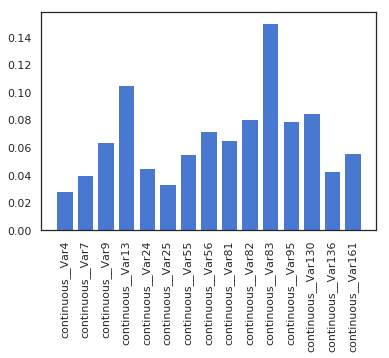

In [25]:
# plot feature improtance
ax = plt.bar(final_cols, us_model.named_steps['classifier'].feature_importances_)
plt.xticks(rotation=90);

no dominant feature

In [26]:
x_train[[i.split('__')[1] for i in final_cols]].corr()

,Var4,Var7,Var9,Var13,Var24,Var25,Var55,Var56,Var81,Var82,Var83,Var95,Var130,Var136,Var161
Var4,1.000000,-0.010410,-0.039027,-0.028028,-0.016645,0.002147,0.054320,0.127854,-0.013011,-0.017458,-0.037693,-0.049473,-0.008091,-0.015061,-0.007736
Var7,-0.010410,1.000000,-0.002303,0.026294,0.285366,0.323802,0.067834,-0.001558,0.122505,-0.016466,0.268342,-0.009187,-0.073214,-0.001535,0.099869
Var9,-0.039027,-0.002303,1.000000,-0.086109,0.021636,0.038030,-0.001121,-0.096249,0.185365,0.697390,0.114772,0.576476,0.080775,0.464360,-0.047401
Var13,-0.028028,0.026294,-0.086109,1.000000,-0.020230,-0.019926,0.003340,0.020946,0.004824,-0.009350,0.013054,-0.030886,-0.012741,0.001996,-0.036859
Var24,-0.016645,0.285366,0.021636,-0.020230,1.000000,0.456394,0.104868,-0.032611,0.096814,-0.006047,0.337967,0.009702,-0.430574,-0.020175,0.238128
Var25,0.002147,0.323802,0.038030,-0.019926,0.456394,1.000000,0.068558,-0.058372,0.140101,-0.021810,0.341814,0.005704,-0.108553,-0.005912,0.190764
Var55,0.054320,0.067834,-0.001121,0.003340,0.104868,0.068558,1.000000,0.004838,0.029484,0.037721,0.073003,0.045340,-0.032695,0.040227,0.047888
Var56,0.127854,-0.001558,-0.096249,0.020946,-0.032611,-0.058372,0.004838,1.000000,-0.065763,-0.040185,-0.103019,-0.098196,-0.061342,-0.017004,-0.007754
Var81,-0.013011,0.122505,0.185365,0.004824,0.096814,0.140101,0.029484,-0.065763,1.000000,0.218606,0.150157,0.170753,-0.010851,0.133446,-0.001530
Var82,-0.017458,-0.016466,0.697390,-0.009350,-0.006047,-0.021810,0.037721,-0.040185,0.218606,1.000000,0.062804,0.543642,0.042881,0.528337,-0.077916


Text(0, 0.5, 'Loans')

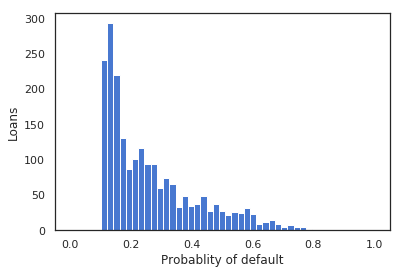

In [27]:
# plot pob distribution
plt.hist(us_model.predict_proba(x_validate)[:,1], bins=np.linspace(0,1));
plt.xlabel('Probablity of default')
plt.ylabel('Loans')

I may need to recalibrate the probablities 

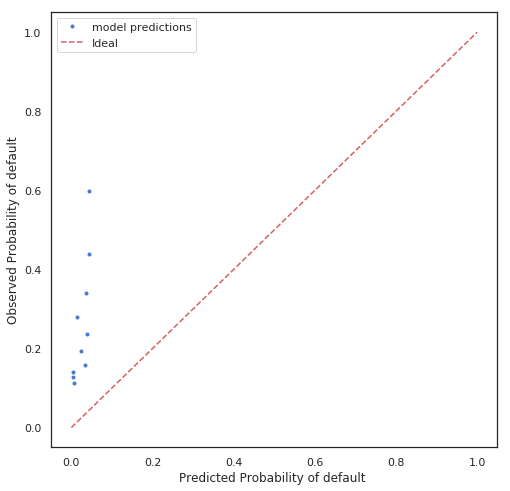

In [28]:
# Look at calibration of probs
fig,ax = plt.subplots(figsize=(8,8))
prob_true,prob_pred = calibration.calibration_curve(y_validate, us_model.predict_proba(x_validate)[:,1],strategy='quantile',n_bins=10)
ax.plot(prob_true, prob_pred,'.',label='model predictions')
ax.plot(np.linspace(0,1), np.linspace(0,1), 'r--', label='Ideal')
#ax.set_xlim((0,.2))
#ax.set_ylim((0,.2))
ax.set_xlabel('Predicted Probability of default ')
ax.set_ylabel('Observed Probability of default')
plt.legend()

Model tends to over under estimate the probablity of default

## check for overfitting

In [29]:
# make learning curves

train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator=us_model,
                                                        X=x_train,
                                                        y=y_train,n_jobs=1,
                                                        train_sizes=np.linspace(0.3, 1., 5),
                                                        cv=model_selection.StratifiedKFold(3),
                                                        scoring=metrics.make_scorer(metrics.recall_score))


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

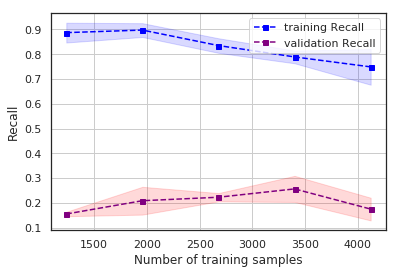

In [30]:
plt.plot(train_sizes, train_mean, color='blue', linestyle='--', marker='s', markersize=5, label='training Recall')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='purple', linestyle='--', marker='s', markersize=5, label='validation Recall')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='red')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Recall')
plt.legend(loc='upper right')
#plt.ylim([0.8, 1.0])
plt.show()


## Tune classifyer params

# Outlier detection model

The class balance is so sevier that outlier detection may work better

In [44]:
# best param
# create pipleline
# continue features
continuous_transformer = Pipeline(steps=[('quantile', preprocessing.QuantileTransformer())])
# ordinal feautres
categorical__ordinal_transformer = Pipeline(steps=[('encode', 'passthrough')])
# Dummy features
dummy_transformer = Pipeline(steps=[('encode', 'passthrough')])
# categorical
categorical__nominal_transformer = Pipeline(steps=[('encoding', ce.BinaryEncoder())])


# put pipelines together
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', categorical__ordinal_transformer,col_type['Categorical Ordinal']),
        ('continuous', continuous_transformer, col_type['Continuous']),
    ('dummy',dummy_transformer, col_type['Dummy']),
    ('nominal',categorical__nominal_transformer,col_type['Categorical Nominal'])])

# create model
outlier_model = Pipeline(steps=[
                      ('preprocessor', preprocessor),
    # feature selection using linear model
                    ('feature selection', feature_selection.SelectFromModel(ensemble.RandomForestClassifier(),max_features=15,prefit=False)),
    # classifier
                      ('classifier', ensemble.IsolationForest(n_estimators=10,bootstrap=True,contamination=0.025))])

model_selection.cross_val_score(outlier_model, x_train, y_train, cv=model_selection.StratifiedKFold(3), scoring='roc_auc')

array([0.48745898, 0.51132039, 0.50011671])

In [45]:
outlier_model.fit(x_train, y_train)
# on model validation sample
print(metrics.classification_report(y_validate, np.int64((outlier_model.predict(x_validate) +1)/2 == 0))) # turn outlires into classes
metrics.recall_score(y_validate, np.int64((outlier_model.predict(x_validate) +1)/2 == 0))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2010
           1       0.05      0.06      0.06        51

    accuracy                           0.95      2061
   macro avg       0.51      0.52      0.52      2061
weighted avg       0.95      0.95      0.95      2061



0.058823529411764705

(array([  1.,  15.,  55., 118., 264., 464., 528., 423., 164.,  29.]),
 array([-0.66060501, -0.63614995, -0.61169489, -0.58723983, -0.56278477,
        -0.5383297 , -0.51387464, -0.48941958, -0.46496452, -0.44050946,
        -0.41605439]),
 <a list of 10 Patch objects>)

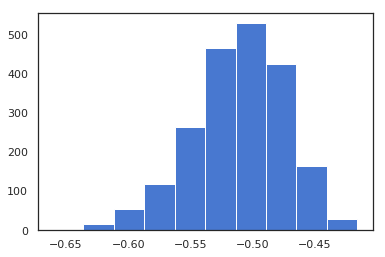

In [46]:
plt.hist(outlier_model.score_samples(x_validate))

# try to turn the scores into probabilites

In [47]:
us = under_sampling.RandomUnderSampler()
x,y = us.fit_resample(outlier_model.score_samples(x_train).reshape(-1,1), y_train)
cal = calibration.CalibratedClassifierCV(method='isotonic').fit(x, y)
metrics.roc_auc_score(y_validate, cal.predict_proba(outlier_model.score_samples(x_validate).reshape(-1,1))[:,1])

0.5754511754950736

Text(0, 0.5, 'Loans')

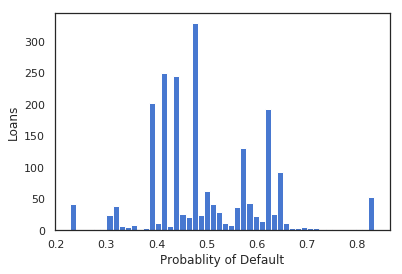

In [48]:
plt.hist(cal.predict_proba(outlier_model.score_samples(x_validate).reshape(-1,1))[:,1], bins=50);
plt.xlabel('Probablity of Default')
plt.ylabel('Loans')

Doesn't seem like recalibrating the scores worked

# Descide which model to use, using out of sample data set

In [49]:
# create data set
x_outsample = all_outsample_df[all_cols]
y_outsample = all_outsample_df['Target']

In [55]:
# best guess model
metrics.recall_score(y_outsample, benchmark_model.predict(x_outsample)),metrics.roc_auc_score(y_outsample, benchmark_model.predict_proba(x_outsample)[:,1])

(0.21951219512195122, 0.613468447624148)

In [56]:
# hyper paramter tuned model
metrics.recall_score(y_outsample, us_model.predict(x_outsample)),metrics.roc_auc_score(y_outsample, us_model.predict_proba(x_outsample)[:,1])

(0.36585365853658536, 0.5336438223687289)

In [52]:
# outliers model
metrics.recall_score(y_outsample, np.int64((outlier_model.predict(x_outsample) +1)/2 == 0))

0.04878048780487805

The hyper paramter tuned model has the best recall, So that is the chosen model.

/opt/conda/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


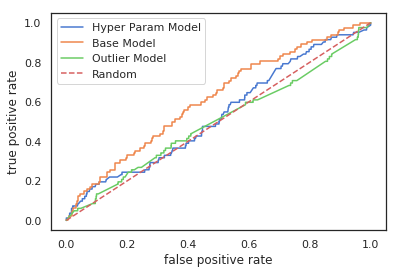

In [61]:
fpr,tpr, thresholds = metrics.roc_curve(y_outsample, us_model.predict_proba(x_outsample)[:,1])
plt.plot(fpr, tpr)
fpr,tpr, thresholds = metrics.roc_curve(y_outsample, benchmark_model.predict_proba(x_outsample)[:,1])
plt.plot(fpr, tpr)
fpr,tpr, thresholds = metrics.roc_curve(y_outsample,cal.predict_proba(outlier_model.score_samples(x_outsample).reshape(-1,1))[:,1])
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1), np.linspace(0,1), 'r--')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(('Hyper Param Model','Base Model','Outlier Model', 'Random'))

In [64]:
# output predictions for OS data
x_outsample['probablity of default'] = benchmark_model.predict_proba(x_outsample)[:,1]
x_outsample['probablity of default'].to_csv('../artifacts/predictions_Tss_v1.csv')

/opt/conda/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Model 1')

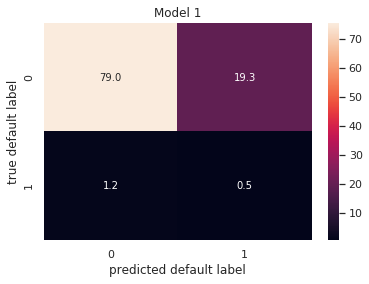

In [63]:
# confusion matrix
test_results = metrics.confusion_matrix(y_outsample, x_outsample['probablity of default']>.4,normalize='all')
sns.heatmap(test_results*100, robust=True, annot=True,fmt='3.1f')
plt.xlabel('predicted default label')
plt.ylabel('true default label')
plt.title('Model 1')